In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from geopy.distance import great_circle
from shapely.geometry import MultiPoint


In [2]:
df = pd.read_csv('GROUP7/ghpb-fpea_clean.tsv',sep='\t')

In [3]:
df.columns

Index(['fare_amount', 'pickup_longitude', 'lpep_dropoff_datetime',
       'lpep_pickup_datetime', 'passenger_count', 'vendorid', 'tolls_amount',
       'dropoff_latitude', 'trip_distance', 'store_and_fwd_flag',
       'payment_type', 'dropoff_longitude', 'ratecodeid', 'total_amount',
       'pickup_latitude', 'extra', 'tip_amount', 'mta_tax', 'trip_type'],
      dtype='object')

In [4]:
df = df[(df[['pickup_longitude','pickup_latitude']] != 0).all(axis=1)]

In [5]:
df.shape

(14723, 19)

In [6]:
df = df.reset_index(drop=True)

In [7]:
df['rid'] = df.index

In [8]:
coords = df.as_matrix(columns=['pickup_latitude', 'pickup_longitude'])

In [9]:
coords.shape

(14723, 2)

In [10]:
kms_per_radian = 6371.0088
epsilon = 2 / kms_per_radian
db = DBSCAN(eps=epsilon, min_samples=4, algorithm='ball_tree', metric='haversine').fit(np.radians(coords))
cluster_labels = db.labels_
num_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)

clusters = pd.Series([coords[cluster_labels == n] for n in range(num_clusters-1)])

In [11]:
np.where(cluster_labels == -1)[0].shape

(17,)

In [12]:
len(np.isin(cluster_labels,-1).astype(int))

14723

In [13]:
print('Number of clusters: {}'.format(num_clusters))

Number of clusters: 3


In [14]:
def get_centermost_point(cluster):
    centroid = (MultiPoint(cluster).centroid.x, MultiPoint(cluster).centroid.y)
    centermost_point = min(cluster, key=lambda point: great_circle(point, centroid).m)
    return tuple(centermost_point)
centermost_points = clusters.map(get_centermost_point)

In [15]:
lats, lons = zip(*centermost_points)
rep_points = pd.DataFrame({'lon':lons, 'lat':lats})

In [16]:
rs = rep_points.apply(lambda row: df[(df['pickup_latitude']==row['lat']) & (df['pickup_longitude']==row['lon'])].iloc[0], axis=1)

In [17]:
df['cluster_id'] = cluster_labels

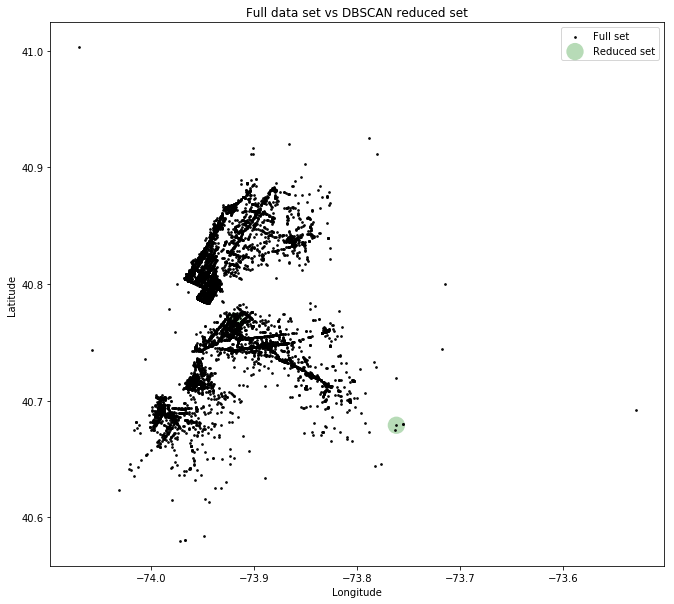

In [18]:
fig, ax = plt.subplots(figsize=[11, 10])
rs_scatter = ax.scatter(rs['pickup_longitude'], rs['pickup_latitude'], c='#99cc99', edgecolor='None', alpha=0.7, s=300)
df_scatter = ax.scatter(df['pickup_longitude'], df['pickup_latitude'], c='k', alpha=0.9, s=3)
ax.set_title('Full data set vs DBSCAN reduced set')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.legend([df_scatter, rs_scatter], ['Full set', 'Reduced set'], loc='upper right')
plt.show()


In [19]:
final_df = df[['rid','pickup_latitude','pickup_longitude','cluster_id']]

In [20]:
final_df.columns = ['rid','latitude','longitude','cluster_id']

In [21]:
final_df.to_csv('ghpb-fpea_clean_dbscan.tsv',sep='\t',index=False)

In [22]:
final_df.shape

(14723, 4)